In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import torch
from skimage import exposure
from scipy.ndimage import label
import math

In [2]:
def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

In [3]:
scene_df1 = pd.read_hdf('scene.hdf5')
scene_df2 = pd.read_hdf('scene2.hdf5')
scene_df3 = pd.read_hdf('scene3.hdf5')
car_scene_df1 = pd.read_hdf('car_scene.hdf5')
car_scene_df2 = pd.read_hdf('car_scene2.hdf5')
car_scene_df3 = pd.read_hdf('car_scene3.hdf5')

In [4]:
car_calibration_df1 = pd.read_hdf("car_calibration_set_1.hdf5")
car_calibration_df2 = pd.read_hdf("car_calibration_set_2.hdf5")
calibration_df1 = pd.read_hdf("calibration_set_1.hdf5")
calibration_df2 = pd.read_hdf("calibration_set_2.hdf5")

In [5]:
def common_values(x, y, threshold=100):
    # Ensure the arrays have the same shape
    assert x.shape == y.shape, "Arrays must have the same shape"
    
    # Create a new array with the common values within the threshold
    common = np.where(np.abs(x - y) <= threshold, x, 0)
    
    return common

In [6]:
def common_values_within_threshold(x, y, threshold=500):
    # Ensure the arrays have the same shape
    assert x.shape == y.shape, "Arrays must have the same shape"
    damean = 0
    # Create a new array with the common values within the threshold
    common = np.where(np.abs(x - y) <= threshold, x,0)
    
    return common, damean

def detect_color_chunks(image, M):
    """
    Detect chunks of pixels with a specified color value in an image.

    Parameters:
    image (np.ndarray): Input 2D image array.
    M (int): Color value to detect.

    Returns:
    list: A list of arrays, where each array contains the indices of a chunk of pixels with the color value M.
    """
    # Ensure the image is a binary image (color value M and others)
    binary_image = (image == M).astype(int)
    
    # Label connected components
    labeled_image, num_features = label(binary_image)
    
    # Extract indices of color value M chunks
    chunks = []
    for i in range(1, num_features + 1):
        chunk_indices = np.argwhere(labeled_image == i)
        chunks.append(chunk_indices)
    
    return chunks

def normalize_image(image):
    # Normalize the image to the range [0, 1]
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def quill_pixels(arr,q1 =0.48 ,q2=0.52, threshold=500, max_iterations=1):
    


    initial_indices = np.random.choice(arr.shape[0], size=60, replace=False)
    initial_subset = arr[initial_indices]
    
    # Update the common image with new mean and median from the subset
    initial_subset_q1 = np.quantile(initial_subset,q1, axis=0)
    initial_subset_q2 = np.quantile(initial_subset,q2, axis=0)
    initial_common, m = common_values_within_threshold(initial_subset_q1, initial_subset_q2, threshold)
    
    black_chunks = detect_color_chunks(initial_common,m)
    
    filled_image = initial_common.copy()
    
    # Store the initial state
    filled_images_history = [filled_image.copy()]
    
    for iteration in range(max_iterations):
        if not black_chunks:
            break
        print(iteration)
        # Randomly select a subset of images
        subset_indices = np.random.choice(arr.shape[0], size=10, replace=False)
        subset = arr[subset_indices]
        
        # Update the common image with new mean and median from the subset
        subset_q1 = np.quantile(subset,q1, axis=0)
        subset_q2 = np.quantile(subset,q2, axis=0)
        subset_common, m = common_values_within_threshold(subset_q1, subset_q2, threshold)
        

        
        # Fill the black pixel chunks
        for chunk in black_chunks:
            for (x, y) in chunk:
                if filled_image[x, y] == 0 and subset_common[x, y] != 0:
                    filled_image[x, y] = subset_common[x, y]
        
        # Store the intermediate filled image
        filled_images_history.append(filled_image.copy())
        
        # Re-detect black chunks
        black_chunks = detect_color_chunks(filled_image,m)
    
    
    
    return filled_image
# Example usage
# arr = np.random.randint(0, 256, (100, 480, 640), dtype=np.uint8)
# final_image, history = fill_black_pixels(arr)



In [7]:
def common_values_within_threshold(x, y, threshold=500):
    # Ensure the arrays have the same shape
    assert x.shape == y.shape, "Arrays must have the same shape"
    
    # Create a new array with the common values within the threshold
    common = np.where(np.abs(x - y) <= threshold, x, 0)
    
    return common

def detect_black_chunks(image):
    # Ensure the image is a binary image (black and white)
    binary_image = (image == 0).astype(int)
    
    # Label connected components
    labeled_image, num_features = label(binary_image)
    
    # Extract indices of black pixel chunks
    chunks = []
    for i in range(1, num_features + 1):
        chunk_indices = np.argwhere(labeled_image == i)
        chunks.append(chunk_indices)
    
    return chunks

def normalize_image(image):
    # Normalize the image to the range [0, 1]
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def fill_black_pixels(arr, threshold=50, max_iterations=100):
    initial_indices = np.random.choice(arr.shape[0], int(arr.shape[0]/10), replace=False)
    initial_subset = arr[initial_indices]
    
    # Update the common image with new mean and median from the subset
    initial_subset_median = np.median(initial_subset, axis=0)
    initial_subset_mean = np.mean(initial_subset, axis=0)
    initial_common = common_values_within_threshold(initial_subset_mean, initial_subset_median, threshold)
    
    black_chunks = detect_black_chunks(initial_common)
    
    filled_image = initial_common.copy()
    
    # Store the initial state
    filled_images_history = [filled_image.copy()]
    
    for iteration in range(max_iterations):
        if not black_chunks:
            break
        
        # Randomly select a subset of images
        subset_indices = np.random.choice(arr.shape[0], size=10, replace=False)
        subset = arr[subset_indices]
        
        # Update the common image with new mean and median from the subset
        subset_median = np.median(subset, axis=0)
        subset_mean = np.mean(subset, axis=0)
        subset_common = common_values_within_threshold(subset_mean, subset_median, threshold)
        
    
        
        # Fill the black pixel chunks
        for chunk in black_chunks:
            for (x, y) in chunk:
                if filled_image[x, y] == 0 and subset_common[x, y] != 0:
                    filled_image[x, y] = subset_common[x, y]
        
        # Store the intermediate filled image
        filled_images_history.append(filled_image.copy())
        
        # Re-detect black chunks
        black_chunks = detect_black_chunks(filled_image)
    

    
    return filled_image, filled_images_history

# Example usage
# arr = np.random.randint(0, 256, (100, 480, 640), dtype=np.uint8)
# final_image, history = fill_black_pixels(arr)



In [8]:
def slice_array(arr, num = 10):
    t, x, y = arr.shape
    
    # Ensure x and y are divisible by 10
    assert x % num == 0 and y % num == 0, "Dimensions x and y must be divisible by 10"
    
    slices = []
    
    for i in range(num):
        for j in range(num):
            slice_x_start = i * (x // num)
            slice_x_end = (i + 1) * (x // num)
            slice_y_start = j * (y // num)
            slice_y_end = (j + 1) * (y // num)
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append(slice_ij)
    
    return slices

def rebuild_array(slices, original_shape, num = 10):
    x, y = original_shape
    
    # Initialize an empty array with the original shape
    rebuilt_array = np.zeros(( x, y))
    
    for idx, slice_ij in enumerate(slices):
        i = idx // num
        j = idx % num
   
        slice_x_start = i * (x // num)
        slice_x_end = (i + 1) * (x // num)
        slice_y_start = j * (y // num)
        slice_y_end = (j + 1) * (y // num)
        
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] = slice_ij
    
    return rebuilt_array

In [9]:
def sorted_uniform_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    variances = np.var(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(variances)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

In [10]:
def sorted_least_mean_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    means = np.mean(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(means)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

In [11]:
def pick_regular_slices(arr,num):
    """
    Pick a tenth of all t slices in a regular order from a (t, x, y) array.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array with a tenth of the t slices picked in a regular order.
    """
    t, x, y = arr.shape
    
    # Compute the indices to pick a tenth of the t slices at regular intervals
    step = t // num
    indices = np.arange(0, t, step)
    
    # Pick slices at the computed indices
    picked_slices = arr[indices]
    
    return picked_slices

In [12]:
def adjust_mean_to_target(arr, target_mean):
    """
    Adjust the values of a 2D array uniformly so that its mean is as close as possible to a target value.

    Parameters:
    arr (np.ndarray): Input 2D array.
    target_mean (float): Target mean value.

    Returns:
    np.ndarray: Adjusted 2D array.
    """
    current_mean = np.mean(arr)
    difference = target_mean - current_mean
    adjusted_array = arr + difference
    return adjusted_array

In [13]:
import numpy as np
from scipy.ndimage import gaussian_filter


def apply_gaussian_blur_along_edges(image_array, num_slices_x, num_slices_y, sigma=2, edge_width=2):
    """
    Apply Gaussian blur along the edges of mosaic blocks to reduce the mosaic effect.

    Parameters:
    image_array (np.ndarray): Input 2D array representing the image.
    num_slices_x (int): Number of slices along the x dimension.
    num_slices_y (int): Number of slices along the y dimension.
    sigma (float): Standard deviation for Gaussian kernel.
    edge_width (int): Width of the effect area around the edges.

    Returns:
    np.ndarray: Processed 2D array with Gaussian blur applied along mosaic edges.
    """
    height, width = image_array.shape
    block_size_x = width // num_slices_x
    block_size_y = height // num_slices_y

    adjusted_image = image_array.copy()

    # Apply Gaussian blur along vertical edges
    for i in range(num_slices_y):
        for j in range(num_slices_x - 1):
            left_edge = adjusted_image[i*block_size_y:(i+1)*block_size_y, (j+1)*block_size_x-edge_width:(j+1)*block_size_x+edge_width]
            adjusted_image[i*block_size_y:(i+1)*block_size_y, (j+1)*block_size_x-edge_width:(j+1)*block_size_x+edge_width] = gaussian_filter(left_edge, sigma=sigma)

    # Apply Gaussian blur along horizontal edges
    for i in range(num_slices_y - 1):
        for j in range(num_slices_x):
            upper_edge = adjusted_image[(i+1)*block_size_y-edge_width:(i+1)*block_size_y+edge_width, j*block_size_x:(j+1)*block_size_x]
            adjusted_image[(i+1)*block_size_y-edge_width:(i+1)*block_size_y+edge_width, j*block_size_x:(j+1)*block_size_x] = gaussian_filter(upper_edge, sigma=sigma)

    return adjusted_image








In [14]:
arr = np.stack(scene_df1["image"].values)


In [18]:
def pseud_calibration(arr, num_slices, reg= 100,adjust =None):

    slices = slice_array(arr, num_slices)
    _, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s) for s in slices]
    original_means = [np.mean(s) for s in slices]

    print(medslice[0].shape)
    tenth = [pick_regular_slices(s,reg) for s in medslice]
    meaned = [np.mean(t, axis=0) for t in tenth]
    if adjust is not None:
        adjusted = [adjust_mean_to_target(m, adjust) for m in meaned]
    return rebuild_array(meaned, (x, y), num_slices)

arr1 = np.stack(scene_df1["image"].values)
filter_scene = pseud_calibration(arr,32)
#filter_scene = adjust_mean_to_target(filter, 200)

arr2 = np.stack(car_scene_df2["image"].values)
filter_car_scene = pseud_calibration(arr2,32)
#filter_car_scene = adjust_mean_to_target(filter_car_scene, 200)

(400, 15, 20)
(1001, 15, 20)


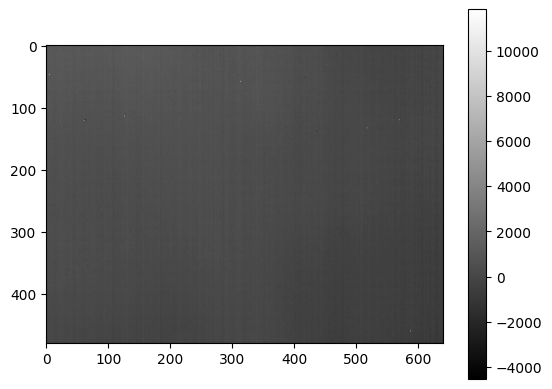

In [ ]:
plt.imshow(filter_car_scene, cmap='gray')
plt.colorbar()

plt.show()

In [19]:
all_vids = [scene_df1,scene_df2,scene_df3]
for i, scene in enumerate(all_vids):
    name = f"Transfered_pseudo_calibration_scenes_{i+1}.avi"
    vid = np.stack(scene["image"].values)
    vid = adjust_mean_to_target(vid, 200)
    save_video_from_images(vid-filter_scene, name)

all_vids2 = [car_scene_df1,car_scene_df2, car_scene_df3]
for i, scene in enumerate(all_vids2):
    name = f"Transfered_pseudo_calibration_car_scenes_{i+1}.avi"
    vid = np.stack(scene["image"].values)
    vid = adjust_mean_to_target(vid, 200)
    save_video_from_images(vid-filter_car_scene, name)